# reproducibility implementation for Optimizing Federated Learning on Non-IID Data with Reinforcement Learning

to have the results, simple run all the cells

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from keras import layers


In [2]:
from sklearn.decomposition import PCA
from random import sample, shuffle

## data loading

In [3]:
from keras.datasets import mnist
(train_X, train_y), (test_X, test_y) = mnist.load_data()


In [4]:
label2index = {}
for _ in set(train_y):
    label2index[_] = (train_y==_)

In [5]:
train_X = train_X.reshape(60000,28,28,1)
test_X = test_X.reshape(10000,28,28,1)
train_y = tf.keras.utils.to_categorical(train_y, 10)
test_y = tf.keras.utils.to_categorical(test_y, 10)

In [6]:
label2index

{0: array([False,  True, False, ..., False, False, False]),
 1: array([False, False, False, ..., False, False, False]),
 2: array([False, False, False, ..., False, False, False]),
 3: array([False, False, False, ..., False, False, False]),
 4: array([False, False,  True, ..., False, False, False]),
 5: array([ True, False, False, ...,  True, False, False]),
 6: array([False, False, False, ..., False,  True, False]),
 7: array([False, False, False, ..., False, False, False]),
 8: array([False, False, False, ..., False, False,  True]),
 9: array([False, False, False, ..., False, False, False])}

[0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]


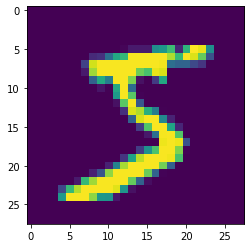

In [8]:
import matplotlib.pyplot as plt
print(train_y[0])
plt.imshow(train_X[0])

## Method to generate non-IID datasets

In [7]:
non_iid_X = {}
non_iid_y = {}
def data_preparation(level_niid):
    global non_iid_X 
    global non_iid_y
    non_iid_X = {}
    non_iid_y = {}
    for _ in range(100):
        non_iid_X[_] = np.zeros((0,28,28,1)) 
        non_iid_y[_] = np.zeros((0,10))
        dominate_class = _%10
        for n in range(10):
            if n==dominate_class:
                non_iid_X[_]=np.concatenate([non_iid_X[_],train_X[label2index[dominate_class]][int(_/10)*int(100*level_niid):int((_/10)+1)*int(100*level_niid)]])
                non_iid_y[_]=np.concatenate([non_iid_y[_],train_y[label2index[dominate_class]][int(_/10)*int(100*level_niid):int((_/10)+1)*int(100*level_niid)]])
            non_iid_X[_]=np.concatenate([non_iid_X[_],train_X[label2index[n]][-int(10-level_niid*10)*(_+1)-1:-int(10-level_niid*10)*_-1]])
            non_iid_y[_]=np.concatenate([non_iid_y[_],train_y[label2index[n]][-int(10-level_niid*10)*(_+1)-1:-int(10-level_niid*10)*_-1]])


## Model declaration

In [9]:
def create_fl_model():
    model = keras.Sequential()
    model.add(layers.Input((28,28,1)))
    model.add(layers.Conv2D(20,kernel_size = (5,5),activation = 'relu'))
    model.add(layers.MaxPooling2D(pool_size = (2,2)))
    model.add(layers.Conv2D(50,kernel_size = (5,5),activation = 'relu'))
    model.add(layers.MaxPooling2D(pool_size = (2,2)))
    model.add(layers.Flatten())
    model.add(layers.Dense(64))
    model.add(layers.Dense(10,activation = 'sigmoid'))
    model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
    return model


def create_q_model():
    model = keras.Sequential()
    model.add(layers.Input(10100))
    model.add(layers.Dense(512))
    model.add(layers.Dense(100,activation = 'sigmoid'))
    model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
    return model




## FL and DDQN part

### train local models and get local weights

In [10]:
#flag to train pca at the 1st episode
pca_init = True
from sklearn.decomposition import PCA
pca = PCA(n_components = 100)

#global variable to store weights
fl_candidates = []

#global variable of states
fl_states = []



def fl_get_state(g_weights, level_niid,need_shuffle = False):
    global pca_init
    global pca
    global fl_candidates
    global fl_states
    global non_iid_X
    global non_iid_y
    fl_candidates = []
    
    orders = list(range(100))
    if need_shuffle:
        shuffle(orders)
        
    #simulate federated learning
    for _ in orders:
        fl_model_agent.set_weights(g_weights)
        
        # 5 epoches
        fl_model_agent.fit(non_iid_X[_],non_iid_y[_],epochs = 2, batch_size = 10,verbose = 0)
        fl_candidates.append( fl_model_agent.get_weights())
        
    #prepare for pca
    X = []
    for wts in fl_candidates:
        X.append(np.concatenate([ary.flatten() for ary in wts]))
    
    #train pca at 1st episode
    if pca_init:
        pca_init = False
        pca.fit(X)
    X.append(np.concatenate([ary.flatten() for ary in g_weights]))
    
    #dim of state after pca: 100*101
    fl_states = pca.transform(X)

    return fl_states

### update global model with selected list of devices

In [11]:
# input: list of agents selected to train the FL
def step(list_taken, level_niid, target_acc = 0.7,need_shuffle = False):
    selected_weights = [fl_candidates[_] for _ in list_taken]
    new_weights = list()
    
    # FedAvg update: compute average weights
    for weights_list_tuple in zip(*fl_candidates): 
        new_weights.append(
            np.array([np.array(w).mean(axis=0) for w in zip(*weights_list_tuple)])
        )
    # update FL server model
    fl_model.set_weights(new_weights)
    
    # return old state, new state, reward and accuracy for DDQN
    acc = fl_model.evaluate(test_X[:1000],test_y[:1000])[1]
    reward = 64**(acc-target_acc)-1
    
    old_state = fl_states
    new_state = fl_get_state(new_weights, level_niid,need_shuffle = need_shuffle)
    return old_state,new_state,reward, acc

###  action selection

In [12]:
def predict_action(mymodel,state,K):
    global epsilon
    # epsilon probability to select randomly
    if np.random.rand() <= epsilon:
        predicted = np.random.rand(100)
    else:
        predicted = mymodel.predict(state.reshape(1,10100))
    # top K
    selected_actions = np.argsort(predicted).flatten()[-K:]
    return selected_actions

In [13]:
import random
from collections import deque

memory = deque([], maxlen=1000)


### DDQN

In [14]:
def train_ddqn(epsilon_decay):
    global memory
    global epsilon
    epsilon_min = 0.1
    minibatch = sample(memory,8)
    x = []
    y = []
    np_array = np.array(minibatch)
    st = np.zeros((0,10100))
    nst = np.zeros( (0,10100) )
    for i in range(len(np_array)):
        st = np.append( st, [np_array[i,0].flatten()], axis=0)
        nst = np.append( nst, [np_array[i,1].flatten()], axis=0)
    st_predict = model_ddqn.predict(st)
    nst_predict = model_ddqn.predict(nst)
    nst_predict_target = model_target.predict(nst)
    index = 0
    for state, nstate, reward, acc, action in minibatch:
        x.append(state)
        #Predict from state
        nst_action_predict_target = nst_predict_target[index]
        nst_action_predict_model = nst_predict[index]
        target = reward + 0.9 * nst_action_predict_target[np.argmax(nst_action_predict_model)] #Double DQN
        target_f = st_predict[index]
        target_f[action] = target
        y.append(target_f)
        index += 1
    x_reshape = np.array(x).reshape(8,10100)
    y_reshape = np.array(y)
    hist = model_ddqn.fit(x_reshape, y_reshape, verbose=0)
    if epsilon > epsilon_min:
        epsilon *= epsilon_decay

In [15]:
memory = deque([], maxlen=1000)

## Experiment

In [16]:
epsilon = 1
def experiment(init_ep,epsilon_decay,level_niid,target_acc = 0.95,max_ep = 120, need_shuffle = False,K=10):
    global fl_model
    global fl_model_agent
    global model_ddqn
    global model_target
    global pca_init
    global memory
    global epsilon
    data_preparation(level_niid)
    epsilon = init_ep
    pca_init = True
    fl_model = create_fl_model()
    fl_model_agent = create_fl_model()
    model_ddqn = create_q_model()
    model_target = create_q_model()

    epsilon_min = 0.1 
    memory = deque([], maxlen=1000)

    acc_per_episode = []
    rwd_per_episode = []
    fl_get_state(fl_model.get_weights(),level_niid,need_shuffle = need_shuffle)
    for e in range(max_ep):
        tot_reward = 0
        action = predict_action(model_ddqn,fl_states,K)
        old_state,new_state,reward,acc = step(action,target_acc, level_niid)
        acc_per_episode.append(acc)
        tot_reward +=reward
        memory.append((old_state,new_state,reward,acc, action))
        if len(memory)>=8:
            train_ddqn(epsilon_decay)
        if e%4 ==0:
            model_target.set_weights(model_ddqn.get_weights())
        if acc>target_acc:
            break
    return acc_per_episode

### Running simulations

In [17]:
final_fedavg = {}
for lvl_niid in [0.9,0.8,0.7,0.5,0.3]:
    final_fedavg[lvl_niid] = experiment(1,1,lvl_niid,target_acc = .97)

32/32 [==============================] - 0s 1ms/step - loss: 0.1001 - accuracy: 0.9710


In [18]:
final_favor = {}
for lvl_niid in [0.9,0.8,0.7,0.5,0.3]:
    final_favor[lvl_niid] = experiment(.9,.9,lvl_niid, target_acc = .97,need_shuffle = True)

32/32 [==============================] - 0s 1ms/step - loss: 0.1146 - accuracy: 0.9700


In [28]:
fedavg_k = {}
for k in [50,100]:
    fedavg_k[k] = experiment(1,1,0.8,target_acc = .97,K=k)

32/32 [==============================] - 0s 1ms/step - loss: 0.1570 - accuracy: 0.9710


### Experiment 1

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

120 rounds for 0.9
120 rounds for 0.8
118 rounds for 0.7
43 rounds for 0.5
29 rounds for 0.3


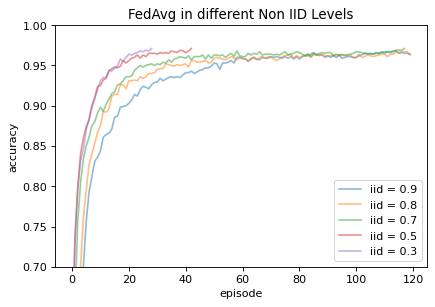

In [42]:
plt.figure(figsize = (6,4),dpi = 80)
for lvl_niid in final_fedavg:
    print('{} rounds for {}'.format(len(final_fedavg[lvl_niid]),lvl_niid))
    plt.plot(final_fedavg[lvl_niid],label = 'iid = {}'.format(lvl_niid),alpha = 0.5)
plt.xlabel('episode')
plt.ylabel('accuracy')
plt.title('FedAvg in different Non IID Levels')
plt.legend()
plt.ylim(.7,1)
plt.savefig('F:/rlfl/fedavg_dif_lvl.eps',format = 'eps')


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

120 rounds for 0.9
98 rounds for 0.8
60 rounds for 0.7
65 rounds for 0.5
104 rounds for 0.3


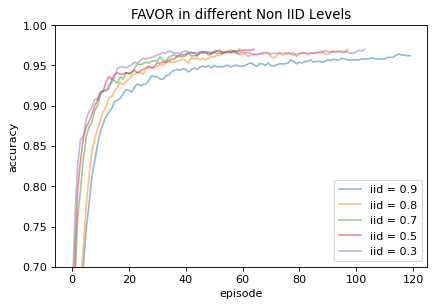

In [45]:
plt.figure(figsize = (6,4),dpi = 80)
for lvl_niid in final_favor:
    print('{} rounds for {}'.format(len(final_favor[lvl_niid]),lvl_niid))
    plt.plot(final_favor[lvl_niid],label = 'iid = {}'.format(lvl_niid),alpha = 0.5)
plt.xlabel('episode')
plt.ylabel('accuracy')
plt.title('FAVOR in different Non IID Levels')
plt.legend()
plt.ylim(.7,1)
plt.savefig('F:/rlfl/favor_dif_lvl.eps',format = 'eps')

### Experiment 2

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


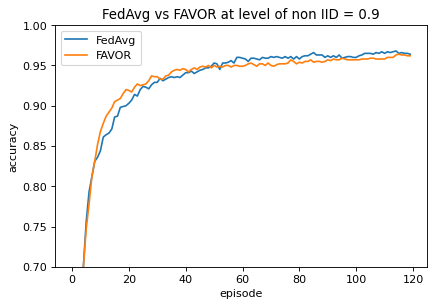

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


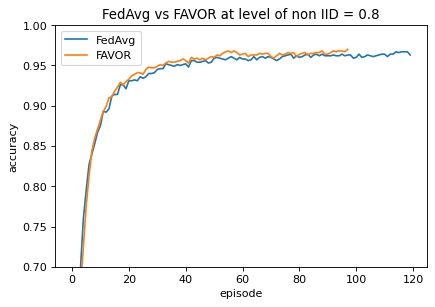

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


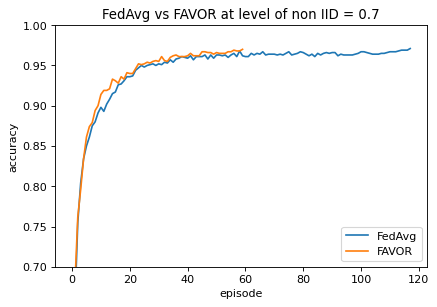

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


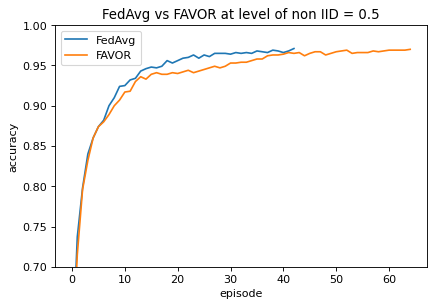

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


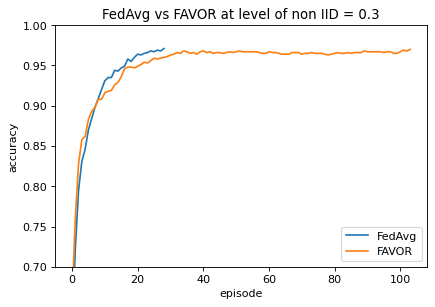

In [44]:
for lvl_niid in final_favor:
    plt.figure(figsize = (6,4),dpi = 80)
    plt.plot(final_fedavg[lvl_niid],label = 'FedAvg')
    plt.plot(final_favor[lvl_niid],label = 'FAVOR')
    plt.xlabel('episode')
    plt.ylabel('accuracy')
    plt.title('FedAvg vs FAVOR at level of non IID = {}'.format(lvl_niid))
    plt.legend()
    plt.ylim(.7,1)
    plt.savefig('F:/rlfl/compare_lvl{}.eps'.format(lvl_niid*100),format = 'eps')
    plt.show()


### Experiment 3

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


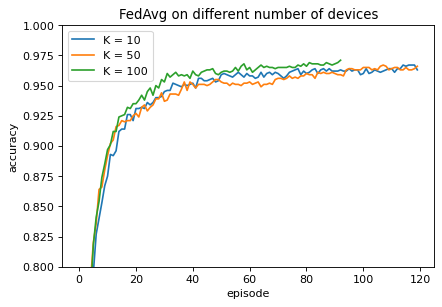

In [46]:
plt.figure(figsize = (6,4),dpi = 80)
plt.plot(final_fedavg[0.8],label = 'K = 10')
for k in fedavg_k:
    plt.plot(fedavg_k[k],label = 'K = {}'.format(k))
plt.xlabel('episode')
plt.ylabel('accuracy')
plt.title('FedAvg on different number of devices')
plt.legend()
plt.ylim(.8,1)
plt.savefig('F:/rlfl/fedavg_dif_k.eps'.format(lvl_niid*100),format = 'eps')
plt.show()